# Marina Lebedina
## ID: 12249127

# HW 7. Variable Selection and Robust Regressions

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import time
from tqdm import tnrange
from pandas.tseries.offsets import BDay
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')
quandl.ApiConfig.api_key = 'bWbMQmPczynWg63DzkA9'
import statsmodels.api as sm
from numpy import linalg
from sklearn import linear_model

# 1. Data processing

## 1.1. Download the data

We will use the last available **41 days** (as specified in hw instruction) from March 26 to May 22, 2020 for model testing and training, in particular:

- Training data: March 26, 2020 - April 23 25, 2020

- Test data: April 24, 2020 - May 22, 2020

In [89]:
a = pd.read_csv('hw4_data copy.csv')
pool = a['Ticker'].values
pool = pool[600:800]

tickers = ['XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLU']

for i in range(len(pool)):
    tickers.append(pool[i])
    
tickers = ['XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLU',\
        'MMM', 'MMSI', 'LPX', 'LOPE', 'MGEE', 'KWR', 'KVHI', 'NC', 'KOP', 'KO',
       'KMT', 'LAWS', 'MWA', 'LBTYA', 'LIN', 'LDL', 'MTW', 'MTX', 'LECO',
       'EXC', 'RGCO', 'ESE', 'EIX', 'ECL']
    
end_date = pd.to_datetime('2020-05-22')
start_date = end_date - BDay(41)

data = pd.DataFrame(index=np.arange(41), columns=tickers)
data

for i in tnrange(len(tickers)):
    ticker = tickers[i]
    raw_data = quandl.get('EOD/{}'.format(ticker), start_date=start_date, end_date=end_date)#['Adj_Close']
    if i==0:
        data['Date'] = raw_data.index
        data = data.set_index('Date')
    data[ticker] = raw_data['Adj_Close']    
    
df = data.pct_change()
df = df.dropna()
df.head(3)

,XLC,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLRE,XLK,...,LIN,LDL,MTW,MTX,LECO,EXC,RGCO,ESE,EIX,ECL
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-27,-0.039964,-0.033514,-0.004650,-0.067785,-0.030457,-0.021416,-0.042128,-0.036150,0.002570,-0.045195,...,-0.039325,-0.090909,-0.130243,-0.034196,-0.051226,-0.029790,-0.037023,-0.113255,-0.041053,-0.026037
2020-03-30,0.036483,0.020908,0.039058,0.010236,0.019039,0.046829,0.014603,0.031857,0.025953,0.042117,...,0.056532,-0.011940,0.034264,0.059421,0.016024,0.048732,0.038062,0.034599,0.028676,0.024892
2020-03-31,-0.001805,-0.020180,-0.020324,0.015374,-0.027557,-0.004384,-0.012385,-0.013795,-0.031855,-0.018681,...,-0.021493,-0.024169,0.042945,0.053763,-0.012734,-0.011281,0.071481,-0.008361,-0.026993,-0.034511


In [77]:
th = 20
 
regressors = df.columns.values[:11]
y_tick = df.columns.values[11:]

X = np.array(df[regressors][:th])

in_df = pd.DataFrame(columns=regressors, index=y_tick)

for i in tnrange(len(y_tick)):
    ticker = y_tick[i]
    y = np.array(df[ticker][:th]).reshape(-1,1)
    model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
    results = model.fit()

    for j in range(len(results.params)):
        beta = results.params[j]
        regr = regressors[j]
        in_df.loc[ticker, regr] = beta

In [78]:
th = 20

regressors = df.columns.values[:11]
y_tick = df.columns.values[11:]

X = np.array(df[regressors][th:])

out_df = pd.DataFrame(columns=regressors, index=y_tick)

for i in tnrange(len(y_tick)):
    ticker = y_tick[i]
    y = np.array(df[ticker][:th]).reshape(-1,1)
    model = sm.OLS(y, X)
    results = model.fit()

    for j in range(len(results.params)):
        beta = results.params[j]
        regr = regressors[j]
        out_df.loc[ticker, regr] = beta

Total L2-norm Beta Error = 28.10


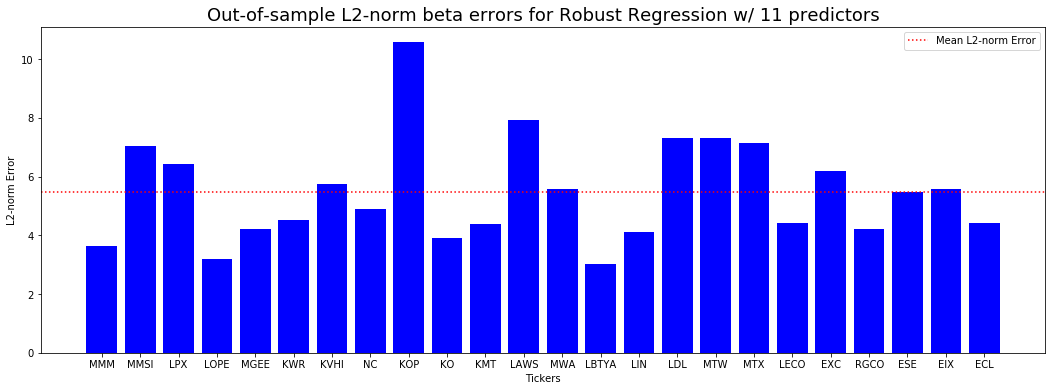

In [79]:
l2_rob = np.linalg.norm(out_df - in_df)

l2_stat = []
for i in range(out_df.shape[0]):
    idx = out_df.index[i]
    l2 = np.linalg.norm(out_df.loc[idx] - in_df.loc[idx])
    l2_stat.append(l2)
    
print('Total L2-norm Beta Error = {:.2f}'.format(l2_rob))

plot_errors(tickers[11:], l2_stat, 'Robust Regression w/ 11 predictors')

In [62]:
th = 20
X = np.array(df[df.columns.values[:11]][:th])
y = np.array(df[df.columns.values[11:]][:th])

model = linear_model.Lasso(fit_intercept=False, max_iter=2000, alpha=0.000001, positive=True)
results = model.fit(X,y)

ans = pd.DataFrame(results.coef_, index=df[df.columns.values[11:]].columns.values, \
                   columns=df[df.columns.values[:11]].columns.values)
ans['!=0'] = len(ans.columns) - ans.eq(0).sum(axis=1)
ans_filter = ans[ans['!=0'] >= 5]
ans_filter.index

Index(['MMM', 'MMSI', 'LPX', 'LOPE', 'MGEE', 'KWR', 'KVHI', 'NC', 'KOP', 'KO',
       'KMT', 'LAWS', 'MWA', 'LBTYA', 'LIN', 'LDL', 'MTW', 'MTX', 'LECO',
       'EXC', 'RGCO', 'ESE', 'EIX', 'ECL'],
      dtype='object')

In [63]:
# tickers = ['XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLU',\
#            'ABB', 'ACHC', 'AME', 'AOS', 'ATR', 'B', 'BDC', 'BKH', 'BRKR',
#            'CCK', 'CFX', 'CMCSA', 'CNP', 'CR', 'CRL', 'CSGS', 'CTS', 'CVCO',
#            'CWT', 'CYH', 'DAR', 'DIS', 'DOV', 'ECL', 'ESE', 'EXC', 'FSS',
#            'FSTR', 'GD', 'GLW']

tickers = ['XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLU',\
        'MMM', 'MMSI', 'LPX', 'LOPE', 'MGEE', 'KWR', 'KVHI', 'NC', 'KOP', 'KO',
       'KMT', 'LAWS', 'MWA', 'LBTYA', 'LIN', 'LDL', 'MTW', 'MTX', 'LECO',
       'EXC', 'RGCO', 'ESE', 'EIX', 'ECL']

end_date = pd.to_datetime('2020-05-22')
start_date = end_date - BDay(41)

print('\nStart date = {}, end date = {}'.format( str(start_date)[:11], str(end_date)[:11] ))
print('\nNumber of tickers under consideration = {}'.format(len(tickers)))


Start date = 2020-03-26 , end date = 2020-05-22 

Number of tickers under consideration = 35


In [64]:
data = pd.DataFrame(index=np.arange(41), columns=tickers)

for i in tnrange(len(tickers)):
    ticker = tickers[i]
    raw_data = quandl.get('EOD/{}'.format(ticker), start_date=start_date, end_date=end_date)#['Adj_Close']
    if i==0:
        data['Date'] = raw_data.index
        data = data.set_index('Date')
    data[ticker] = raw_data['Adj_Close']    

## 1.2. Convert adjusted close prices to daily returns 

In [65]:
df = data.pct_change()
df = df.dropna()
df.head(3)

,XLC,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLRE,XLK,...,LIN,LDL,MTW,MTX,LECO,EXC,RGCO,ESE,EIX,ECL
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-27,-0.039964,-0.033514,-0.004650,-0.067785,-0.030457,-0.021416,-0.042128,-0.036150,0.002570,-0.045195,...,-0.039325,-0.090909,-0.130243,-0.034196,-0.051226,-0.029790,-0.037023,-0.113255,-0.041053,-0.026037
2020-03-30,0.036483,0.020908,0.039058,0.010236,0.019039,0.046829,0.014603,0.031857,0.025953,0.042117,...,0.056532,-0.011940,0.034264,0.059421,0.016024,0.048732,0.038062,0.034599,0.028676,0.024892
2020-03-31,-0.001805,-0.020180,-0.020324,0.015374,-0.027557,-0.004384,-0.012385,-0.013795,-0.031855,-0.018681,...,-0.021493,-0.024169,0.042945,0.053763,-0.012734,-0.011281,0.071481,-0.008361,-0.026993,-0.034511


# 2. Robust Regression with 11 predictors 

In [80]:
def run_robust(regressors, tickers):
    th = 20
    predictors = regressors # array
    X = np.array(df[predictors][:th]) # in-sample

    in_df = pd.DataFrame(columns=regressors, index=tickers)
    
    for i in range(len(tickers)):
        ticker = tickers[i]
        y = np.array(df[ticker][:th])
        model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
        results = model.fit()

        for j in range(len(results.params)):
            beta = results.params[j]
            regr = regressors[j]
            in_df.loc[ticker, regr] = beta

    return in_df

# 3. (c1, c3, c6) unconstrained and (d1, d3, d6) positive Lasso Regressions

In [81]:
def run_regr(thres, pos_bool):
    
    th = 20
    X = np.array(df[df.columns.values[:11]][:th])
    y = np.array(df[df.columns.values[11:]][:th])

    alphas = np.linspace(0.000001, 0.003, 1000)

    found = []
    stat = {}

    max_num = 0

    for i in tnrange(len(alphas), desc='Finding alpha'):
        if len(found) == len([df.columns.values[11:]][0]):
            print('Found!')
            break
        else:
            alpha = alphas[i]
#             print(alpha, pos_bool, found)
            model = linear_model.Lasso(fit_intercept=False, max_iter=2000, alpha=alpha, positive=pos_bool)
            results = model.fit(X,y)

            ans = pd.DataFrame(results.coef_, index=df[df.columns.values[11:]].columns.values, \
                               columns=df[df.columns.values[:11]].columns.values)
            ans['!=0'] = len(ans.columns) - ans.eq(0).sum(axis=1)

            ans_filter = ans[ans['!=0'] == thres]

            for j in range(ans_filter.shape[0]):

                idx = ans_filter.index[j]

                if idx in found:
                    pass
                else:
                    df_idx = pd.DataFrame(ans_filter.loc[idx][:-1])
                    col = np.where(df_idx != 0)[0]
                    stat_ticker = []
                    for k in range(len(col)):
                        stat_ticker.append(df_idx.index[col[k]])
                    stat_ticker.append(alpha)
                    stat[idx] = stat_ticker
                    found.append(idx)
                    
    if len(found) != len([df.columns.values[11:]][0]):
        for i in tnrange(len(alphas)):
            if len(found) == len([df.columns.values[11:]][0]):
                print('Found!')
                break
            else:
                alpha = alphas[i]
                model = linear_model.Lasso(fit_intercept=False, max_iter=2000, alpha=alpha, positive=pos_bool)
                results = model.fit(X,y)

                ans = pd.DataFrame(results.coef_, index=df[df.columns.values[11:]].columns.values, \
                                   columns=df[df.columns.values[:11]].columns.values)
                ans['!=0'] = len(ans.columns) - ans.eq(0).sum(axis=1)

                ans_filter = ans[ans['!=0'] == thres-1]

                for j in range(ans_filter.shape[0]):

                    idx = ans_filter.index[j]

                    if idx in found:
                        pass
                    else:
                        df_idx = pd.DataFrame(ans_filter.loc[idx][:-1])
                        col = np.where(df_idx != 0)[0]
                        stat_ticker = []
                        for k in range(len(col)):
                            stat_ticker.append(df_idx.index[col[k]])
                        stat_ticker.append(alpha)
                        stat[idx] = stat_ticker
                        found.append(idx)
    
    return found, stat

# False 1, 3, (6)
# True 1, 3, (6)

# 5. Comparison of models performance

## 5.1. Robust Regression w/ 11 predictors vs. out-of-sample OLS 

In [90]:
# Out-of-sample OLS betas (i.e. "true" betas)
def run_ols(regressors, tickers):
    th = 20
    predictors = regressors # array
    X = np.array(df[predictors][th:]) # out-of-sample

    out_df = pd.DataFrame(columns=regressors, index=tickers)
    
    for i in range(len(tickers)):
        ticker = tickers[i]
        y = np.array(df[ticker][th:]) # out-of-sample
        model = sm.OLS(y, X)
        results = model.fit()

        for j in range(len(results.params)):
            beta = results.params[j]
            regr = regressors[j]
            out_df.loc[ticker, regr] = beta
            
    print(out_df.shape)

    return out_df

In [91]:
def plot_errors(tickers, l2_stat, name):
    fig, ax = plt.subplots(figsize=(18,6))
    ax.bar(tickers, l2_stat, color='blue')
    plt.axhline(y=np.mean(l2_stat), color='r', linestyle=':', label='Mean L2-norm Error')
    plt.xlabel('Tickers')
    plt.ylabel('L2-norm Error')
    plt.title('Out-of-sample L2-norm beta errors for {}'.format(name), fontsize=18)
    plt.legend()
    None

(24, 11)
Total L2-norm Beta Error = 22.48


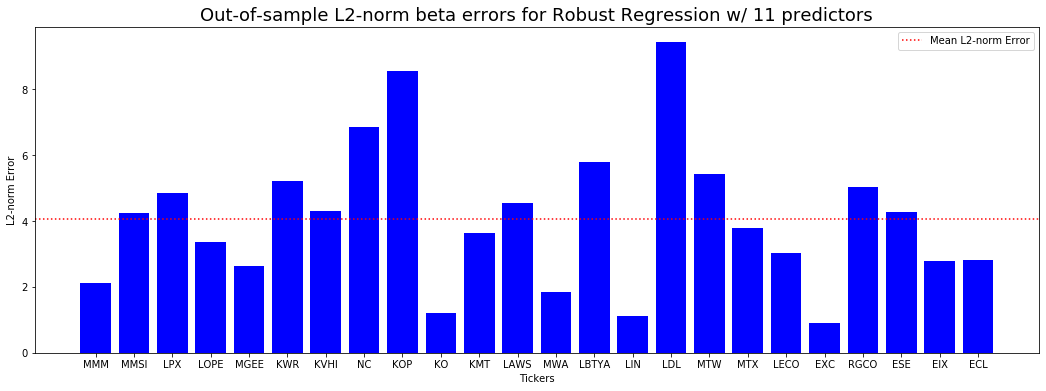

In [92]:
# Run OLS and Robust Regression with all 11 predictors
rob_out = run_ols(tickers[:11], tickers[11:])
rob_in = run_robust(tickers[:11], tickers[11:])

l2_rob = np.linalg.norm(rob_out - rob_in)

l2_stat = []
for i in range(rob_out.shape[0]):
    idx = rob_out.index[i]
    l2 = np.linalg.norm(rob_out.loc[idx] - rob_in.loc[idx])
    l2_stat.append(l2)
    
print('Total L2-norm Beta Error = {:.2f}'.format(l2_rob))

plot_errors(tickers[11:], l2_stat, 'Robust Regression w/ 11 predictors')

## 5.1. Constrained and Unconstrained Lasso w/ 1,3,6 predictors vs. out-of-sample OLS 

In [93]:
def run_lasso(X, y, ticker, predictors, alpha, pos_bool):
    model = linear_model.Lasso(fit_intercept=False, max_iter=1000, alpha=alpha, positive=pos_bool)
    results = model.fit(X,y)
    return pd.DataFrame(results.coef_, index=predictors, columns=ticker).T
   
def run_analysis(pos_bool, thres):
    
    tick_found, stat_dict = run_regr(thres, pos_bool)
    
    th = 20
    dim1 = False

    in_lasso = {}
    out_ols = {}
    l2_lasso = []

    for key, val in stat_dict.items():
        if len(val) == 2:
            ticker = key
            predictors = val[0]
            alpha = val[1]
            dim1 = True
        elif len(val) == 4:
            ticker = key
            predictors = val[0:3]
            alpha = val[3]
            dim1 = False
        elif len(val) == 6:
            ticker = key
            predictors = val[0:5]
            alpha = val[5]
            dim1 = False
        elif len(val) == 7:
            ticker = key
            predictors = val[0:6]
            alpha = val[6]
            dim1 = False

        if dim1 == False:
            X = np.array(df[predictors][:th])
            y = np.array(df[ticker][:th]).reshape(-1,1)
        else:
            X = np.array(df[predictors][:th]).reshape(-1,1)
            y = np.array(df[ticker][:th]).reshape(-1,1)

        if thres == 1:
            predictors = [predictors]
            
#         print(ticker, alpha, pos_bool)
        res_in = run_lasso(X, y, [ticker], predictors, alpha, pos_bool)
        res_out = run_ols(predictors, [ticker])
        l2 = np.linalg.norm(res_out - res_in)

        in_lasso[ticker] = res_in
        out_ols[ticker] = res_out
        l2_lasso.append(l2)
        
    print('Total L2-norm Beta Error = {:.5f}'.format(np.array(l2_lasso).sum()))
    
    return in_lasso, out_ols, l2_lasso

In [94]:
in_lasso_c1, out_ols_c1, l2_lasso_c1 = run_analysis(False, 1)
in_lasso_c3, out_ols_c3, l2_lasso_c3 = run_analysis(False, 3)
in_lasso_c6, out_ols_c6, l2_lasso_c6 = run_analysis(False, 6)

in_lasso_d1, out_ols_d1, l2_lasso_d1 = run_analysis(True, 1)
in_lasso_d3, out_ols_d3, l2_lasso_d3 = run_analysis(True, 3)
in_lasso_d6, out_ols_d6, l2_lasso_d6 = run_analysis(True, 6)

Found!
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
Total L2-norm Beta Error = 20.14679


Found!
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
Total L2-norm Beta Error = 29.30202


Found!
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 5)
(1, 5)
(1, 5)
Total L2-norm Beta Error = 46.85125


Found!
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
Total L2-norm Beta Error = 20.14679


KeyboardInterrupt: 

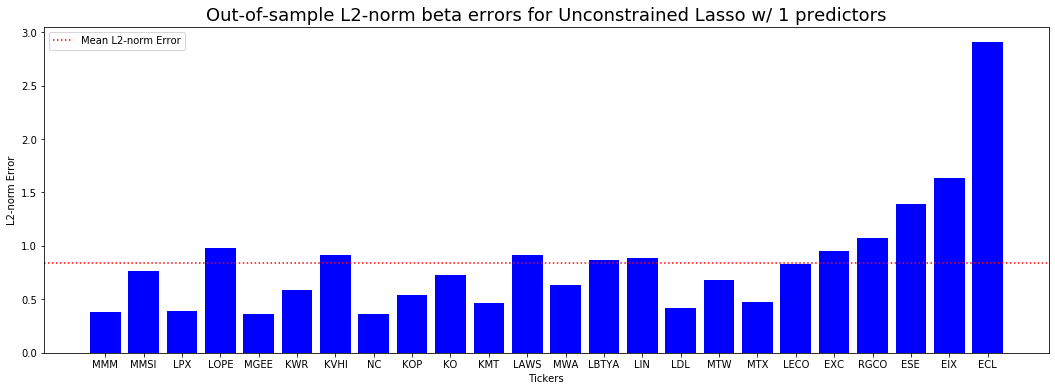

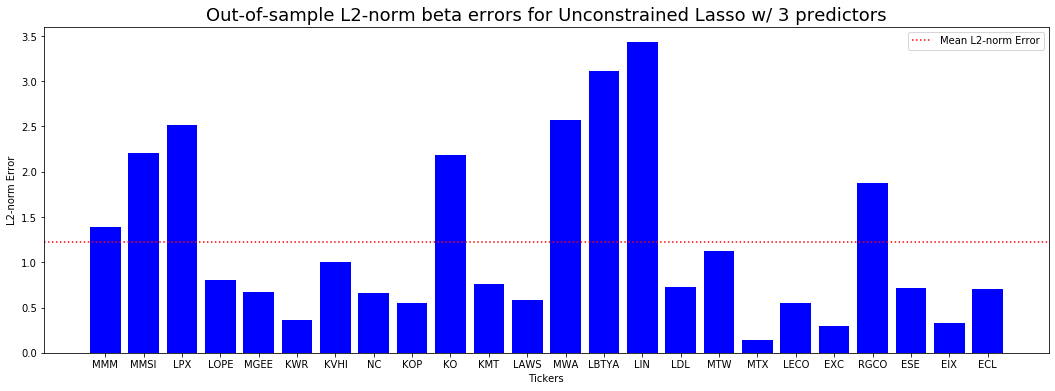

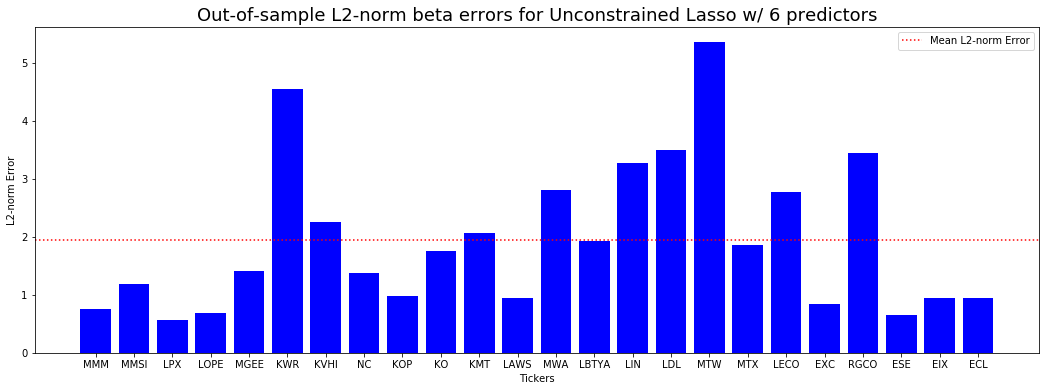

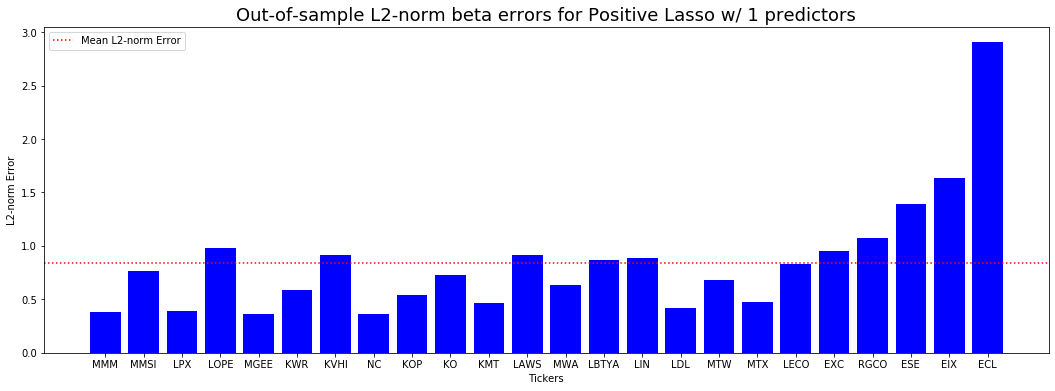

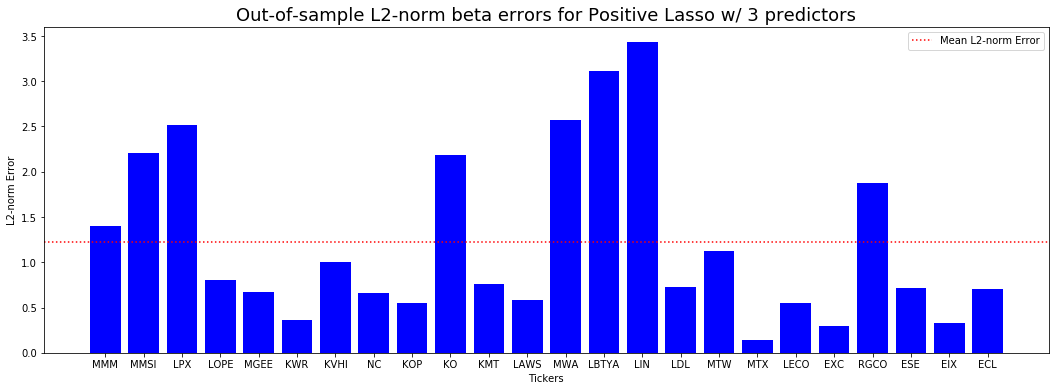

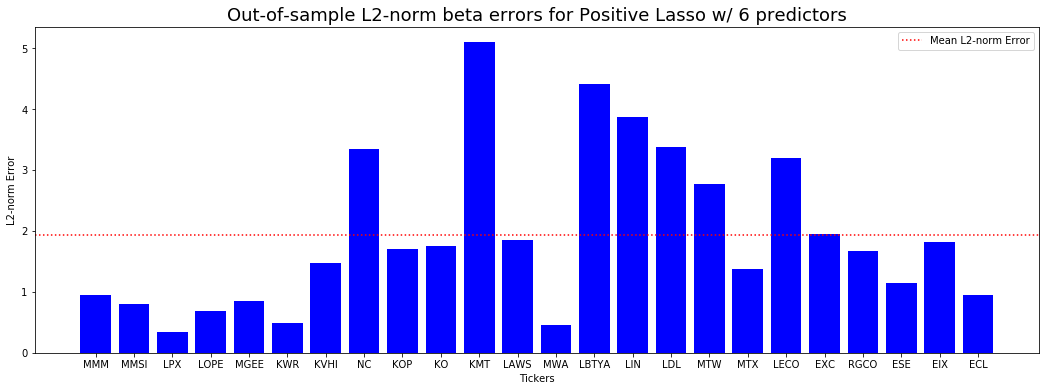

In [73]:
plot_errors(tickers[11:], l2_lasso_c1, 'Unconstrained Lasso w/ {} predictors'.format(1))
plot_errors(tickers[11:], l2_lasso_c3, 'Unconstrained Lasso w/ {} predictors'.format(3))
plot_errors(tickers[11:], l2_lasso_c6, 'Unconstrained Lasso w/ {} predictors'.format(6))

plot_errors(tickers[11:], l2_lasso_d1, 'Positive Lasso w/ {} predictors'.format(1))
plot_errors(tickers[11:], l2_lasso_d3, 'Positive Lasso w/ {} predictors'.format(3))
plot_errors(tickers[11:], l2_lasso_d6, 'Positive Lasso w/ {} predictors'.format(6))

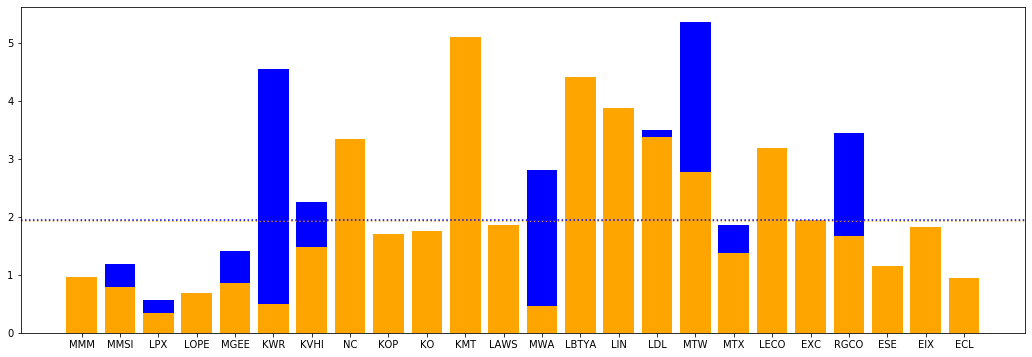

In [74]:
fig, ax = plt.subplots(figsize=(18,6))
ax.bar(tickers[11:],  l2_lasso_c6, color='blue')
ax.bar(tickers[11:],  l2_lasso_d6, color='orange')
plt.axhline(y=np.mean(l2_lasso_d6), color='orange', linestyle=':', label='Mean L2-norm Error d6')
plt.axhline(y=np.mean(l2_lasso_c6), color='blue', linestyle=':', label='Mean L2-norm Error c6')

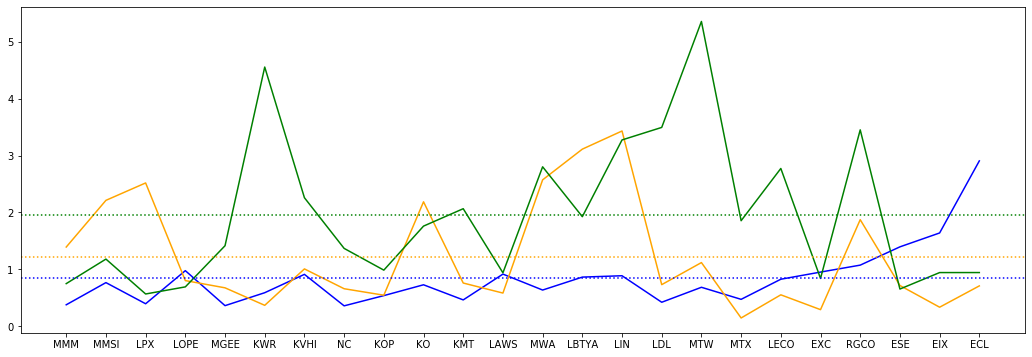

In [75]:
fig, ax = plt.subplots(figsize=(18,6))

ax.plot(tickers[11:],  l2_lasso_c1, color='blue')
ax.plot(tickers[11:],  l2_lasso_c3, color='orange')
ax.plot(tickers[11:],  l2_lasso_c6, color='green')

plt.axhline(y=np.mean(l2_lasso_c1), color='blue', linestyle=':', label='Mean L2-norm Error d6')
plt.axhline(y=np.mean(l2_lasso_c3), color='orange', linestyle=':', label='Mean L2-norm Error c6')
plt.axhline(y=np.mean(l2_lasso_c6), color='green', linestyle=':', label='Mean L2-norm Error c6')

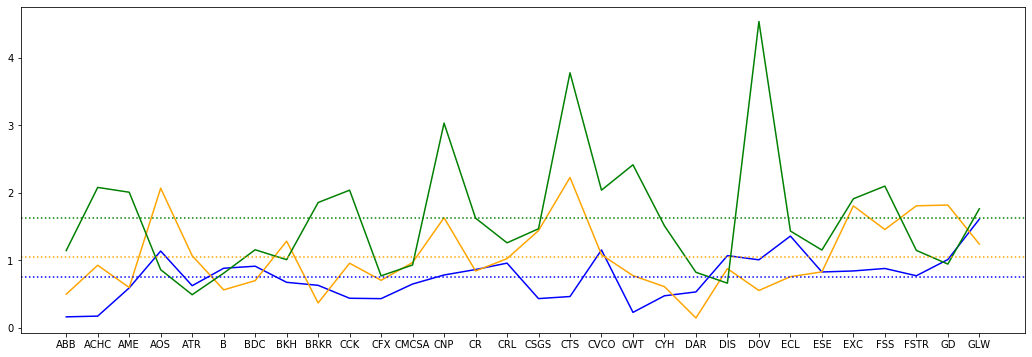

In [52]:
fig, ax = plt.subplots(figsize=(18,6))

ax.plot(tickers[11:],  l2_lasso_d1, color='blue')
ax.plot(tickers[11:],  l2_lasso_d3, color='orange')
ax.plot(tickers[11:],  l2_lasso_d6, color='green')

plt.axhline(y=np.mean(l2_lasso_d1), color='blue', linestyle=':', label='Mean L2-norm Error d6')
plt.axhline(y=np.mean(l2_lasso_d3), color='orange', linestyle=':', label='Mean L2-norm Error c6')
plt.axhline(y=np.mean(l2_lasso_d6), color='green', linestyle=':', label='Mean L2-norm Error c6')